In [2]:
import sys
sys.path.append('../')
sys.path.append('../support/')
from scipy.ndimage import measurements
from scipy.ndimage import interpolation
from time import time
from glob import glob
import timeit
from os.path import join, basename, isfile
from tqdm import tqdm
from ct_reader import *
import dicom
from scipy.misc import imresize
from multiprocessing import Pool
import pickle
from paths import *
from scipy.ndimage import morphology
from lung_separation import *
import seaborn as sns
import pandas as pd
import cv2
import lung_separation_frontal
%pylab inline
%load_ext autoreload
%autoreload 1
%aimport lung_separation_frontal

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
with open(join(PATH['STAGE_MASKS'],'erroneus')) as f:
    err_file_names = [it.rstrip() for it in f.readlines()]

UnicodeDecodeError: 'ascii' codec can't decode byte 0x80 in position 0: ordinal not in range(128)

In [15]:
pickle.dump(err_file_names,open(join(PATH['STAGE_MASKS'],'erroneus.pkl'),'wb'))

In [2]:
# err_file_names = load(join(PATH['STAGE_MASKS'],'erroneus'))
# err_file_names.append('4dbda61d574417c7f25d6e9a8f0749a7')
# save(join(PATH['WEIGHTS'],'erroneus'),err_file_names)

OSError: Failed to interpret file '/home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/data/NEW_STAGE/MASKS/erroneus' as a pickle

bad lungs: 0,5,11,14,16,19,23

In [4]:
err_file_names = load(join(PATH['STAGE_MASKS'],'erroneus'))

In [5]:
err_lungs = []
# separated = []
for f_name in tqdm(err_file_names):
    ct = read_ct_scan(join(PATH['STAGE_DATA'],f_name))
    nparr = get_pixels_hu(ct)
    err_lungs.append(nparr)
#     separated.append(load(join(PATH['DATA_OUT'],f_name+'.npy')))

100%|██████████| 30/30 [01:01<00:00,  2.12s/it]


  0%|          | 0/30 [00:00<?, ?it/s]

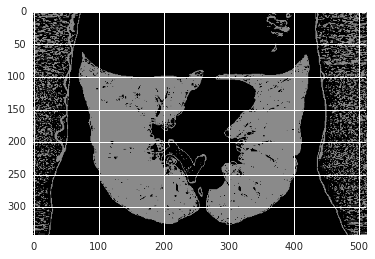

  3%|▎         | 1/30 [00:10<05:16, 10.90s/it]

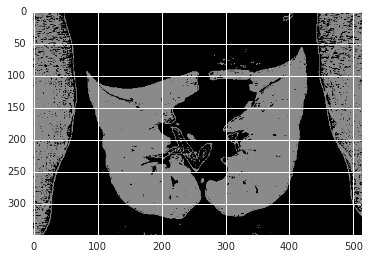

  7%|▋         | 2/30 [00:20<04:54, 10.51s/it]

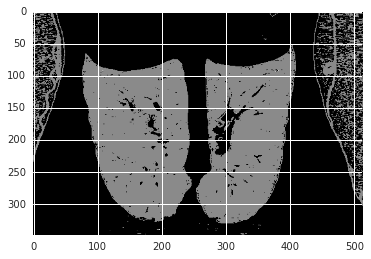

 10%|█         | 3/30 [00:30<04:43, 10.49s/it]

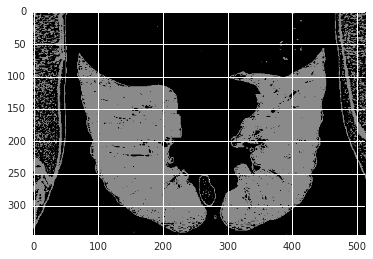

 13%|█▎        | 4/30 [00:41<04:33, 10.54s/it]

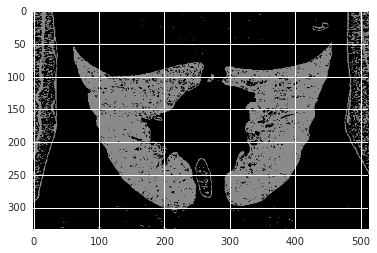

 17%|█▋        | 5/30 [00:51<04:17, 10.29s/it]

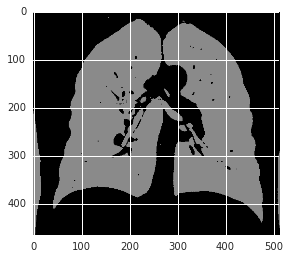

 20%|██        | 6/30 [01:01<04:05, 10.25s/it]

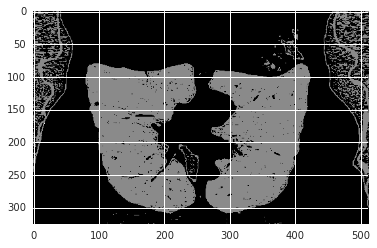

 23%|██▎       | 7/30 [01:11<03:51, 10.07s/it]

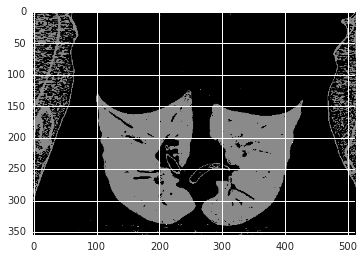

 27%|██▋       | 8/30 [01:21<03:41, 10.06s/it]

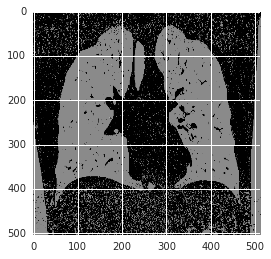

 30%|███       | 9/30 [01:40<04:29, 12.85s/it]

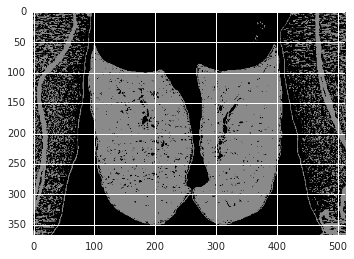

 33%|███▎      | 10/30 [01:52<04:12, 12.63s/it]

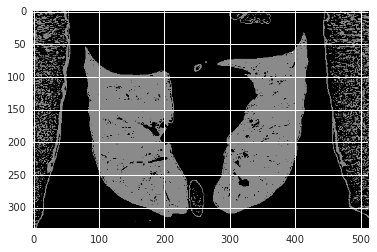

 37%|███▋      | 11/30 [02:03<03:48, 12.05s/it]

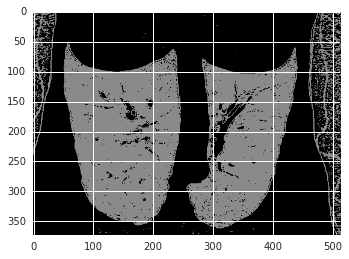

 40%|████      | 12/30 [02:14<03:30, 11.70s/it]

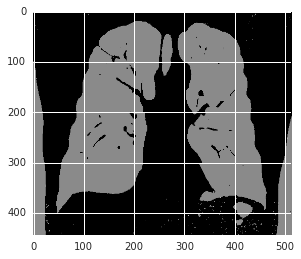

 43%|████▎     | 13/30 [02:23<03:09, 11.12s/it]

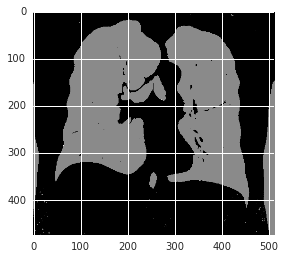

 47%|████▋     | 14/30 [02:34<02:53, 10.84s/it]

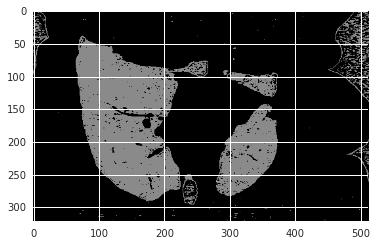

 50%|█████     | 15/30 [02:43<02:34, 10.30s/it]

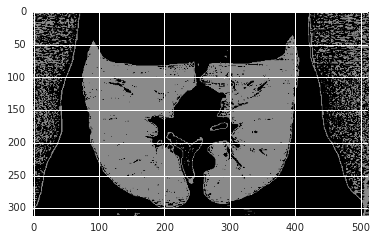

 53%|█████▎    | 16/30 [02:52<02:21, 10.13s/it]

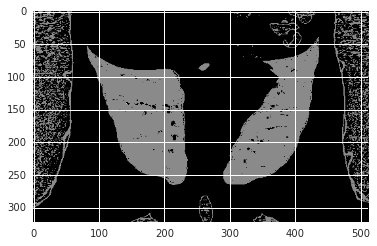

 57%|█████▋    | 17/30 [03:05<02:21, 10.86s/it]

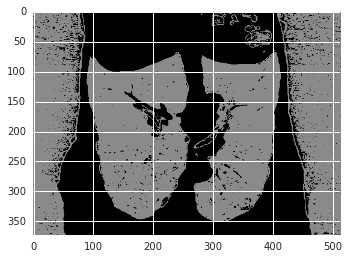

 60%|██████    | 18/30 [03:15<02:06, 10.51s/it]

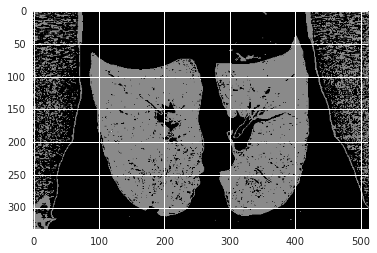

 63%|██████▎   | 19/30 [03:25<01:55, 10.53s/it]

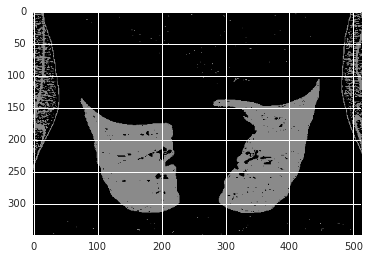

 67%|██████▋   | 20/30 [03:35<01:42, 10.29s/it]

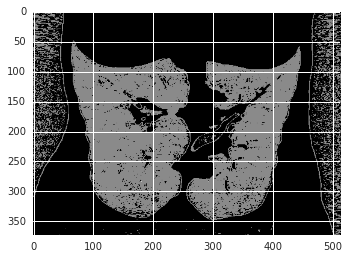

 70%|███████   | 21/30 [03:49<01:42, 11.35s/it]

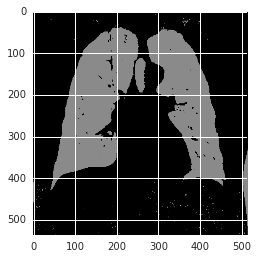

 73%|███████▎  | 22/30 [04:03<01:37, 12.21s/it]

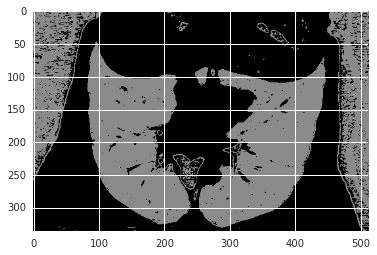

 77%|███████▋  | 23/30 [04:12<01:18, 11.26s/it]

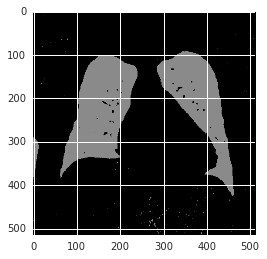

 80%|████████  | 24/30 [04:23<01:07, 11.21s/it]

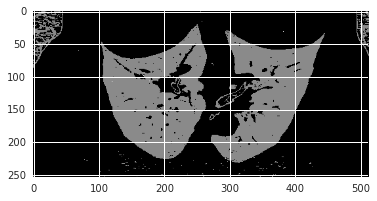

 83%|████████▎ | 25/30 [04:30<00:49,  9.90s/it]

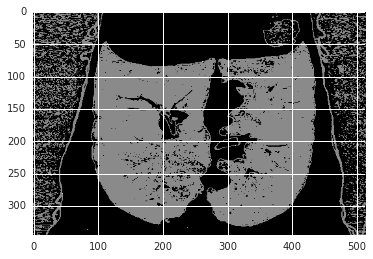

 87%|████████▋ | 26/30 [04:41<00:41, 10.36s/it]

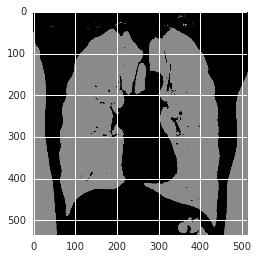

 90%|█████████ | 27/30 [04:53<00:32, 10.77s/it]

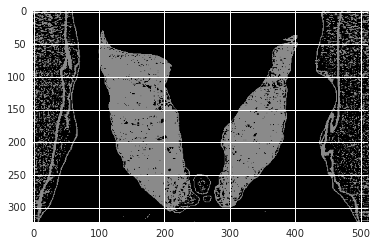

 93%|█████████▎| 28/30 [05:04<00:21, 10.90s/it]

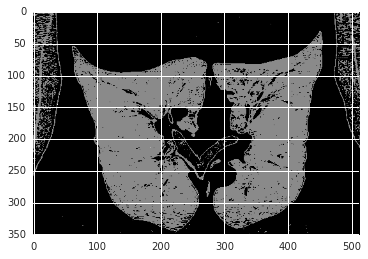

 97%|█████████▋| 29/30 [05:15<00:10, 10.80s/it]

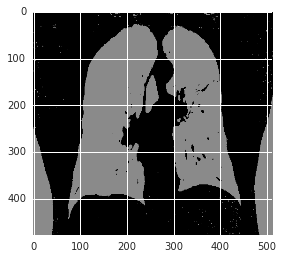

100%|██████████| 30/30 [05:26<00:00, 10.73s/it]


In [6]:
ocv_masks = list()
for img_3 in tqdm(err_lungs):
    img_3d = img_3.copy()
    for img in img_3d:
        # threshold HU > -300
        img[img>-300] = 255
        img[img<-300] = 0
        img = uint8(img)

        # find surrounding torso from the threshold and make a mask
        im2, contours, _ = cv2.findContours(img,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
        largest_contour = max(contours, key=cv2.contourArea)
        mask = zeros(img.shape, uint8)
        cv2.fillPoly(mask, [largest_contour], 255)

        # apply mask to threshold image to remove outside. this is our new mask
        img = ~img
        img[(mask == 0)] = 0 # <-- Larger than threshold value

        # apply closing to the mask
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15))
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)  # <- to remove speckles...
        img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
        img = cv2.morphologyEx(img, cv2.MORPH_DILATE, kernel)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
        img = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
    plt.imshow(img_3d[:,256,:])
    plt.show()
    ocv_masks.append(img_3d.copy())

In [8]:
for i in tqdm(range(len(ocv_masks))):
    save(join(PATH['STAGE_MASKS'],'FIXED','ocv_'+err_file_names[i]),ocv_masks[i])

100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


In [18]:
ocv_masks = []
for fname in err_file_names:
    ocv_masks.append(load(join(PATH['STAGE_MASKS'],'FIXED','ocv_'+fname+'.npy'))==0)

In [17]:
where(ocv_masks[0]==-300)

(array([  0,   0,   0, ..., 342, 342, 342]),
 array([130, 182, 251, ..., 302, 422, 459]),
 array([271, 382, 399, ...,  31, 282, 352]))


  0%|          | 0/30 [00:00<?, ?it/s]

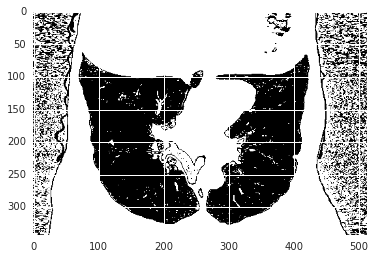



  0%|          | 0/343 [00:00<?, ?it/s]

  6%|▌         | 19/343 [00:00<00:01, 180.23it/s]

 11%|█         | 38/343 [00:00<00:01, 180.93it/s]

 16%|█▋        | 56/343 [00:00<00:01, 178.26it/s]

 22%|██▏       | 75/343 [00:00<00:01, 179.06it/s]

 27%|██▋       | 93/343 [00:00<00:01, 176.28it/s]

 32%|███▏      | 109/343 [00:00<00:01, 168.04it/s]

 36%|███▌      | 124/343 [00:00<00:01, 161.15it/s]

 41%|████      | 140/343 [00:00<00:01, 158.43it/s]

 45%|████▌     | 155/343 [00:00<00:01, 154.57it/s]

 50%|████▉     | 170/343 [00:01<00:01, 152.06it/s]

 54%|█████▍    | 185/343 [00:01<00:01, 151.03it/s]

 59%|█████▊    | 201/343 [00:01<00:00, 150.66it/s]

 63%|██████▎   | 216/343 [00:01<00:00, 149.95it/s]

 68%|██████▊   | 232/343 [00:01<00:00, 150.45it/s]

 72%|███████▏  | 247/343 [00:01<00:00, 148.82it/s]

 76%|███████▋  | 262/343 [00:01<00:00, 147.63it/s]

 81%|████████  | 278/343 [00:01<00:00, 148.87it/s]

 86%|████████▌ | 294/343 [00:01<00:00, 151.30it/s]

 91%|█████████ | 311/343 [

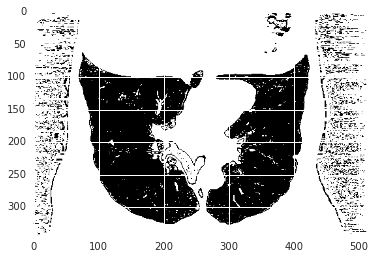



  0%|          | 0/102 [00:00<?, ?it/s]

finding start slice




  1%|          | 1/102 [00:00<00:38,  2.60it/s]

  2%|▏         | 2/102 [00:00<00:38,  2.61it/s]

  3%|▎         | 3/102 [00:01<00:37,  2.65it/s]

  4%|▍         | 4/102 [00:01<00:36,  2.72it/s]

  5%|▍         | 5/102 [00:01<00:35,  2.69it/s]

  6%|▌         | 6/102 [00:02<00:36,  2.66it/s]

  7%|▋         | 7/102 [00:02<00:34,  2.73it/s]

  8%|▊         | 8/102 [00:02<00:35,  2.65it/s]

  9%|▉         | 9/102 [00:03<00:36,  2.53it/s]

 10%|▉         | 10/102 [00:03<00:36,  2.55it/s]

 11%|█         | 11/102 [00:04<00:35,  2.55it/s]

 12%|█▏        | 12/102 [00:04<00:34,  2.60it/s]

 13%|█▎        | 13/102 [00:04<00:34,  2.62it/s]

 14%|█▎        | 14/102 [00:05<00:33,  2.62it/s]

 15%|█▍        | 15/102 [00:05<00:32,  2.70it/s]

 16%|█▌        | 16/102 [00:06<00:31,  2.73it/s]

 17%|█▋        | 17/102 [00:06<00:30,  2.77it/s]

 18%|█▊        | 18/102 [00:06<00:30,  2.79it/s]

 19%|█▊        | 19/102 [00:07<00:29,  2.77it/s]

 20%|█▉        | 20/102 [00:07<00:30,  2.66it/s]

 21%|██

KeyboardInterrupt: 

In [23]:
new_separated = []
for i in tqdm(range(len(ocv_masks))):
    mask =  ocv_masks[i].copy()
    plt.imshow(mask[:,255,:])
    plt.show()
    for j in tqdm(range(mask.shape[0])):
        mask[j] = clear_border(mask[j])
    plt.imshow(mask[:,255,:])
    plt.show()
    left, right = lung_separation_frontal.separate_lungs3d(mask==0)
    msk = left+right*2
    new_separated[i] = msk.copy()
    plt.imshow(msk[:,255,:])
    plt.show()
    plt.imshow(msk[msk.shape[0]//2])
    plt.show()

In [30]:
mask[slic].shape

MemoryError: 

3,11,18,19,35

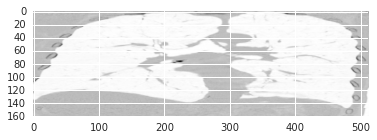

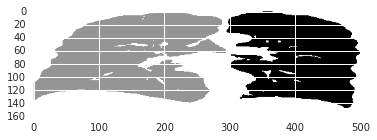

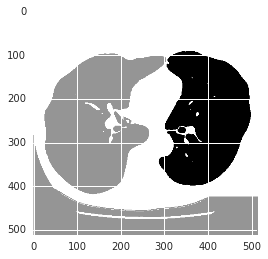

In [6]:
i = 35
plt.imshow(err_lungs[i][:,255,:])
plt.show()
plt.imshow(separated[i][:,255,:])
plt.show()
plt.imshow(separated[i][separated[i].shape[0]//2])
plt.show()

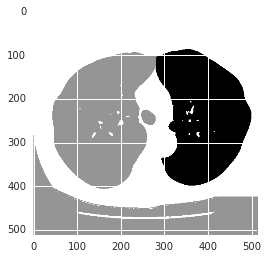

In [20]:
plt.imshow(separated[35][50])

In [91]:
for i in tqdm(range(len(err_file_names))):
    save(join(PATH['DATA_OUT'],err_file_names[i]+'.npy'),separated[i])

100%|██████████| 39/39 [00:34<00:00,  1.19it/s]


In [ ]:
(left+right*2).shape

In [24]:
mask, count = label((ocv_masks[0]==0)[:,255,:], connectivity=1, return_num=True)

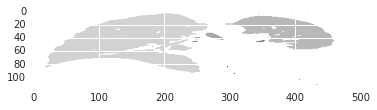

In [26]:
plt.imshow(mask)

In [39]:
ss_err = []
for i in [3,11,18,19,35]:
    ss_err.append(err_file_names[i])
save(join(PATH['WEIGHTS'],'still_still_erroneus'),asarray(ss_err))

In [40]:
load(join(PATH['WEIGHTS'],'still_still_erroneus'))

FileNotFoundError: [Errno 2] No such file or directory: '/home/a.dobrenkii/Projects/Kaggle/DataScienceBowl2K17/data/WEIGHTS/still_still_erroneus'